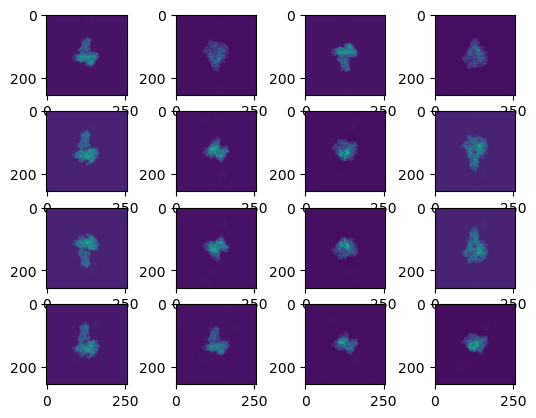

In [11]:
import mrcfile as mrc
import matplotlib.pyplot as plt
import numpy as np
import healpy
from scipy.spatial.transform import Rotation
from scipy.interpolate import RegularGridInterpolator

pdb = '8F76'
m = mrc.open('{0}.mrc'.format(pdb),'r')
volume = np.asarray(m.data)
psize = m.voxel_size['x']


grid = [np.arange(x) -x//2 for x in volume.shape]


# Fourier transform volume
volfft = np.fft.ifftshift(np.fft.fftn(np.fft.fftshift(volume)))

# We will need to "interpolate" the grid - estimate values in between the pixels and this
# function prepares for that
vol = RegularGridInterpolator(grid,volfft,method="linear",bounds_error=False,fill_value=0)

def project_volume(vol,rot,tilt,psi,returnfft=False):
    R = Rotation.from_euler('zyz',[rot,tilt,psi],degrees=False).as_matrix()
    
    # Generate coordinates of plane normal to projection direction
    x = R[0].reshape((3,1))*np.arange(-volume.shape[0]//2,volume.shape[0]//2).reshape((1,volume.shape[0]))
    y = R[1].reshape((3,1))*np.arange(-volume.shape[1]//2,volume.shape[1]//2).reshape((1,volume.shape[0]))
    g = (x.reshape(3,volume.shape[0],1)+y.reshape(3,1,volume.shape[1])).reshape(3,np.product(volume.shape[:2])).T
    
    # Extract plane
    fftprojection = vol(g).reshape(volume.shape[:2])
    projection = np.fft.ifftshift(np.real(np.fft.ifft2(np.fft.fftshift(fftprojection))))/volume.shape[0]
    
    if returnfft:
        return projection,fftprojection
    else:
        return projection
fig,ax = plt.subplots(nrows=4,ncols=4)
for i in range(16):
    rot,tilt = healpy.pixelfunc.pix2ang(16,i)
    ax[i//4,i%4].imshow(project_volume(vol,rot,tilt,0))
